In [73]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import tensorflow as tf

# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

In [377]:
%%time
dataset = []
for folder in ["../audio_files/full_set/set_a/**","../audio_files/full_set/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
#             Extrastole and extrahls don't indicate any illness
            if (label == 'extrastole' or label == 'extrahls'):
                label = 'normal'
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=41)

Wall time: 905 ms


<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 49 to 396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  404 non-null    object
 1   label     404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


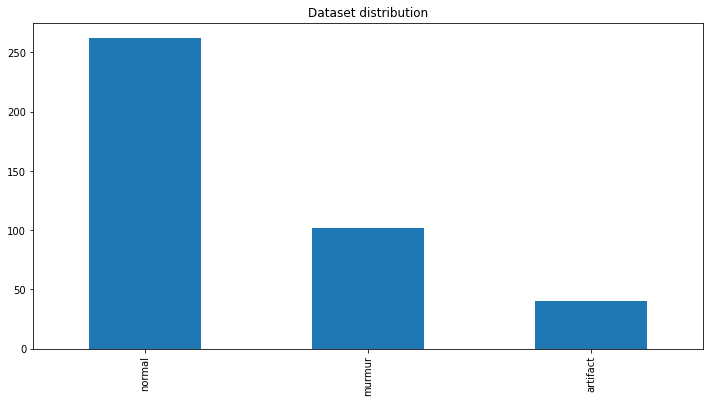

In [378]:
dataset.info()
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [428]:
train, test = train_test_split(dataset, test_size=0.2, random_state=46)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 323
Test: 81


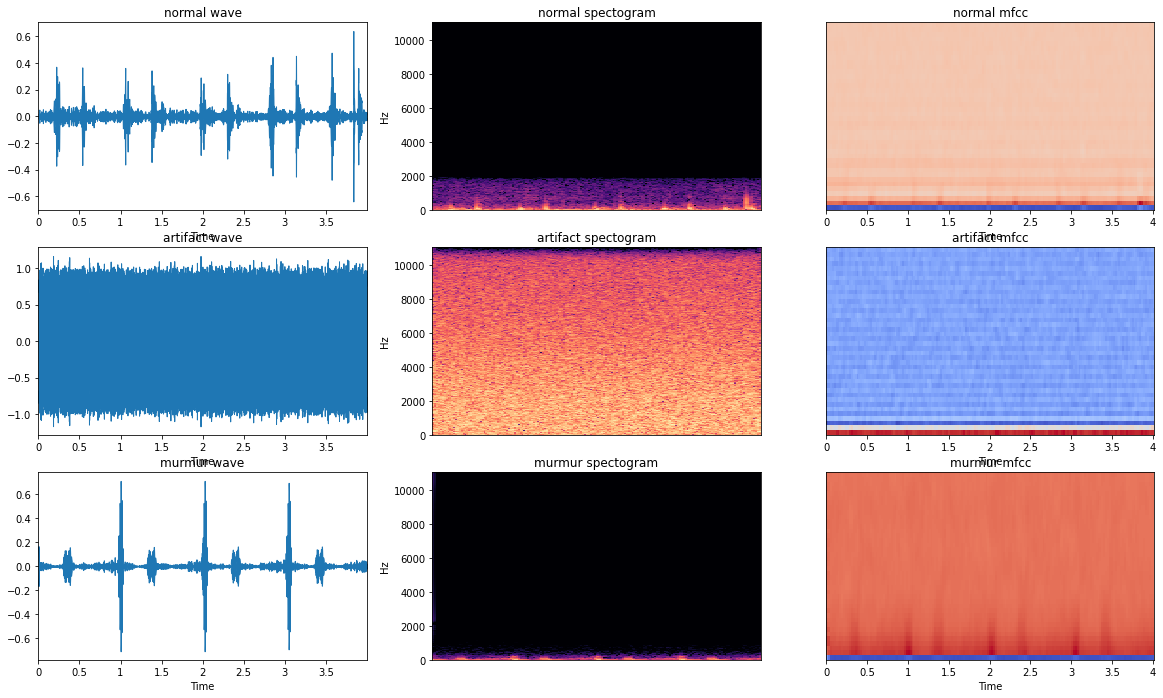

Wall time: 1.44 s


In [429]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[6], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()

In [430]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [493]:
# %%time
# x_train, x_test = [], []
# print("Extract features from TRAIN  and TEST dataset")
# for idx in tqdm(range(len(train))):
#     x_train.append(train.filename.iloc[idx])

# for idx in tqdm(range(len(test))):
#     x_test.append(test.filename.iloc[idx])
    
    
# x_test = np.asarray(x_test)
# x_train = np.asarray(x_train)

# print("X train:", x_train.shape)
# print("X test:", x_test.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 26844.08it/s]

Extract features from TRAIN  and TEST dataset
X train: (323,)
X test: (81,)
Wall time: 16.9 ms


In [431]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  1%|▍                                                            | 2/323 [00:00<00:28, 11.35it/s]

Extract features from TRAIN  and TEST dataset


100%|█████████████████████████████████████████████████████████████| 81/81 [00:09<00:00,  8.75it/s]

X train: (323, 40, 173)
X test: (81, 40, 173)
Wall time: 45.3 s


In [432]:
%%time
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

Wall time: 997 µs


In [433]:
y_int = np.array(list(map(np.argmax, y_train)))
np.unique(y_train)

array([0, 1, 2])

In [435]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [436]:
class_weights = {0: class_weights[0]/3, 1: class_weights[1]/3, 2: class_weights[2] *6}; #, 3: class_weights[3]/3, 4: class_weights[4] *3}
class_weights

{0: 1.0875420875420876, 1: 0.47222222222222227, 2: 3.018691588785047}

In [437]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (323, 40, 173, 1)
Y train: (323, 3)

X test: (81, 40, 173, 1)
Y test: (81, 3)


In [438]:
model = Sequential()

# model.add(keras.layers.Activation(extract_features))

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
# model.summary()

In [439]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# tf.keras.metrics.FalseNegatives()

In [440]:
%%time
# history = model.fit(np.array(train.filename.iloc), np.array(test.filename.iloc),
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=100,
               validation_data=(x_test, y_test),
#               validation_split=0.25,
              class_weight=class_weights,
              shuffle=True)

Epoch 1/100
3/3 [==============================] - 1s 290ms/step - loss: 61.4778 - accuracy: 0.1862 - val_loss: 6.5917 - val_accuracy: 0.5926
Epoch 2/100
3/3 [==============================] - 1s 203ms/step - loss: 9.6831 - accuracy: 0.6766 - val_loss: 11.3975 - val_accuracy: 0.5926
Epoch 3/100
3/3 [==============================] - 1s 203ms/step - loss: 16.3780 - accuracy: 0.6574 - val_loss: 10.9190 - val_accuracy: 0.5926
Epoch 4/100
3/3 [==============================] - 1s 204ms/step - loss: 14.6752 - accuracy: 0.6623 - val_loss: 8.3860 - val_accuracy: 0.5926
Epoch 5/100
3/3 [==============================] - 1s 202ms/step - loss: 13.2294 - accuracy: 0.6623 - val_loss: 5.5529 - val_accuracy: 0.5926
Epoch 6/100
3/3 [==============================] - 1s 209ms/step - loss: 8.8415 - accuracy: 0.6682 - val_loss: 3.4266 - val_accuracy: 0.5926
Epoch 7/100
3/3 [==============================] - 1s 204ms/step - loss: 6.4017 - accuracy: 0.6643 - val_loss: 1.9119 - val_accuracy: 0.5926
Epoch 8

Epoch 59/100
3/3 [==============================] - 1s 199ms/step - loss: 0.6000 - accuracy: 0.7265 - val_loss: 0.6791 - val_accuracy: 0.6790
Epoch 60/100
3/3 [==============================] - 1s 210ms/step - loss: 0.6358 - accuracy: 0.7240 - val_loss: 0.6896 - val_accuracy: 0.6790
Epoch 61/100
3/3 [==============================] - 1s 206ms/step - loss: 0.6178 - accuracy: 0.7360 - val_loss: 0.6900 - val_accuracy: 0.6790
Epoch 62/100
3/3 [==============================] - 1s 216ms/step - loss: 0.5876 - accuracy: 0.7542 - val_loss: 0.6823 - val_accuracy: 0.6790
Epoch 63/100
3/3 [==============================] - 1s 253ms/step - loss: 0.5773 - accuracy: 0.7402 - val_loss: 0.6858 - val_accuracy: 0.6790
Epoch 64/100
3/3 [==============================] - 1s 217ms/step - loss: 0.5586 - accuracy: 0.7459 - val_loss: 0.6941 - val_accuracy: 0.6790
Epoch 65/100
3/3 [==============================] - 1s 215ms/step - loss: 0.6600 - accuracy: 0.7222 - val_loss: 0.6851 - val_accuracy: 0.6790
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

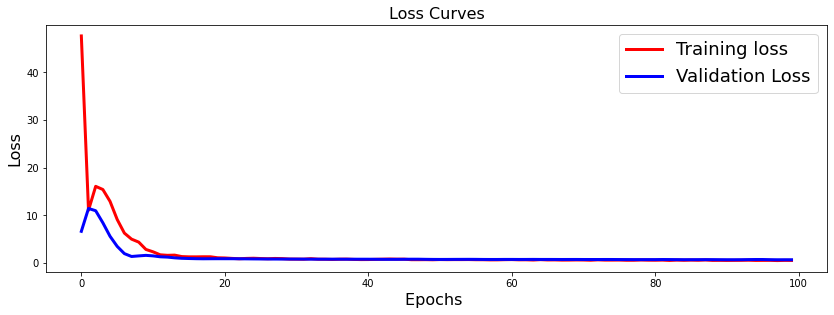

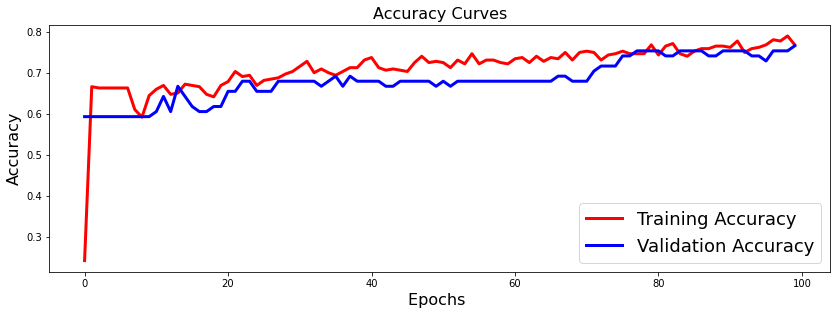

In [441]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [442]:
# Save model and weights
model_name = "heartbeat_disease_artifact_weights.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at heartbeat_disease_artifact_weights.h5 


In [443]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 14ms/step - loss: 0.6198 - accuracy: 0.7654
Test loss: 0.6197509765625
Test accuracy: 0.7654321193695068


In [444]:
predictions = model.predict(x_test, verbose=1)

3/3 [==============================] - 0s 14ms/step


In [445]:
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

In [451]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=40)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=25)
    plt.yticks(tick_marks, classes, fontsize=25)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25})

    plt.ylabel('True label', fontsize=35)
    plt.xlabel('Predicted label', fontsize=35)
    plt.tight_layout()

    plt.show()

In [447]:
print(confusion_matrix(y_pred,y_true))
print(classification_report(y_pred, y_true))

[[ 7  0  1]
 [ 0  8  0]
 [ 0 18 47]]
              precision    recall  f1-score   support

    artifact       1.00      0.88      0.93         8
      murmur       0.31      1.00      0.47         8
      normal       0.98      0.72      0.83        65

    accuracy                           0.77        81
   macro avg       0.76      0.87      0.75        81
weighted avg       0.91      0.77      0.81        81



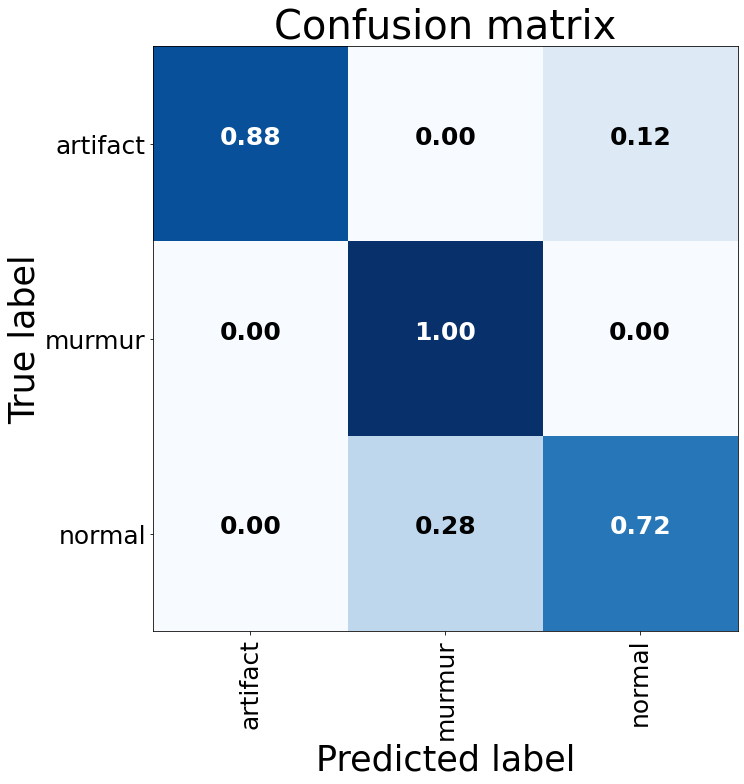

In [452]:
cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)